# In this notebook we will add the final features we decided that can be worthy to help our predictions

## ✅ Current Feature Set Summary (with Explanations)

| 🏷️ Feature           | 🧠 Meaning                                                                 | 📈 Why It Helps                                                                   | ⚠️ Notes / Considerations                          |
|----------------------|---------------------------------------------------------------------------|-----------------------------------------------------------------------------------|----------------------------------------------------|
| **roc_4h**            | 4-hour rate of change (short-term momentum)                              | Detects quick market moves and intraday trend shifts                             | Strong on its own; moderately correlated to `ret_over_atr` |
| **roc_24h**           | 24-hour rate of change (daily momentum)                                  | Helps capture new trends or possible reversals over a 1-day window               | Highly correlated with `price_above_ma50` (⚠️ consider dropping) |
| **roc_7days**         | 7-day rate of change (weekly momentum)                                   | Filters out noise and focuses on sustained directional bias                      | Unique info; low correlation — keep                |
| **body**              | Difference between open and close price (candle body size)               | Shows strength of buyers or sellers — large bodies suggest strong pressure       | Safe and low redundancy                            |
| **upper_shadow**      | Distance between high and close/open (top wick size)                     | Indicates price rejection at the top — potential bearish pressure                | Some overlap with volatility measures              |
| **lower_shadow**      | Distance between low and close/open (bottom wick size)                   | Suggests buyer support or rejection of lower prices                              | Useful for candle psychology                       |
| **boll_b**            | Position inside Bollinger Bands (0 = lower band, 1 = upper band)         | Reveals if price is at extremes — potential breakout or reversal                 | Moderately correlated with `roc_4h`, but adds value |
| **vol_ratio_24h**     | Current volume ÷ 24-hour average volume                                  | Detects unusual activity — volume spikes may precede strong price movement       | Low correlation; high signal potential             |
| **ret_over_atr**      | Momentum normalized by volatility (roc_4h ÷ ATR)                         | Helps detect meaningful momentum in context of recent volatility                 | Correlated with `roc_4h` — watch model performance |
| **band_width**        | Width of Bollinger Bands (volatility measure)                            | Measures volatility — narrow bands can signal breakouts                          | Low correlation — keep                             |
| **tr**                | True Range (high - low adjusted)                                         | Captures real intraday volatility range                                          | Feeds into ATR; moderate correlation               |
| **atr_14**            | Average True Range over 14 periods                                       | Measures recent volatility with smoothing                                        | Strong correlation with `close` — acceptable       |
| **price_above_ma50**  | Price divided by 50-period moving average                                | Captures trend direction and strength                                            | ⚠️ Highly correlated with `roc_24h` — may drop one |
| **open**              | Opening price of candle                                                  | Used to compute candle body and shadows                                          | ❌ Redundant with `close` — candidate for removal  |
| **high**              | Highest price of candle                                                  | Used in shadows and TR calculation                                               | ❌ Redundant — candidate for removal               |
| **low**               | Lowest price of candle                                                   | Used in shadows and TR calculation                                               | ❌ Redundant — candidate for removal               |
| **close**             | Closing price of candle                                                  | Common anchor price in TA features                                               | ✅ Keep — essential reference price                 |


In [3]:
# ─────────────────────────── Paths & imports ────────────────────────────────
from pathlib import Path
import pandas as pd

SRC = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
           r"\Stock-Market-Prediction\data\processed"
           r"\gemini_btc_data_final_version.csv")
OUT = SRC.with_name(SRC.stem + "_with_features.csv")

# ─────────────────────────── Load & prepare ────────────────────────────────
df = (
    pd.read_csv(SRC)
      .rename(columns=str.strip)              # trim stray spaces
      .assign(date=lambda d: pd.to_datetime(d["date"]))
      .sort_values("date")                    # chronological order
      .reset_index(drop=True)
)

# ─────────────────────────── Candlestick anatomy (shifted) ────────────────
# All three use the *previous* candle → no leakage
df["body"]         = (df["close"] - df["open"]).shift(1)
df["upper_shadow"] = (df["high"]  - df[["close", "open"]].max(axis=1)).shift(1)
df["lower_shadow"] = (df[["close", "open"]].min(axis=1) - df["low"]).shift(1)

# ─────────────────────────── Momentum features ─────────────────────────────
df["roc_4h"]    = df["close"].pct_change(  4)          #  4 × 1-hour bars
df["roc_24h"]   = df["close"].pct_change( 24)          # 24 × 1-hour bars
df["roc_7days"] = df["close"].pct_change(24 * 7)       # 168 × 1-hour bars

# ─────────────────────────── Bollinger-band position (shifted) ────────────
mid = df["close"].rolling(window=20, min_periods=20).mean().shift(1)
std = df["close"].rolling(window=20, min_periods=20).std().shift(1)
lower = mid - 2 * std
upper = mid + 2 * std
df["boll_b"] = ((df["close"] - lower) / (upper - lower)).clip(0, 1)

# ─────────────────────────── Volume spike detector ─────────────────────────
vol_mean_24h = df["Volume BTC"].rolling(window=24, min_periods=1).mean().shift(1)
df["vol_ratio_24h"] = df["Volume BTC"] / vol_mean_24h

# ─────────────────────────── Persist & inspect ─────────────────────────────
#df.to_csv(OUT, index=False)
#print(f"✅  Leak-free features saved → {OUT}")
#df.head().T     # quick peek (transpose for readability)


✅  Leak-free features saved → C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version_with_features.csv


,0,1,2,3,4
date,2015-10-08 14:00:00,2015-10-08 15:00:00,2015-10-08 16:00:00,2015-10-08 17:00:00,2015-10-08 18:00:00
open,245.0,245.0,244.92,244.25,244.99
high,245.0,245.0,244.92,244.99,244.99
low,244.5,244.92,244.25,244.02,244.0
close,245.0,244.92,244.25,244.99,244.0
Volume BTC,4.453649,3.016926,3.895252,3.920632,3.690472
body,NaN,0.0,-0.08,-0.67,0.74
upper_shadow,NaN,0.0,0.0,0.0,0.0
lower_shadow,NaN,0.5,0.0,0.0,0.23
roc_4h,NaN,NaN,NaN,NaN,-0.004082


In [4]:
SRC = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
           r"\Stock-Market-Prediction\data\processed"
           r"\gemini_btc_data_final_version_with_features.csv")
OUT = SRC.with_name(SRC.stem + "_with_features.csv")

# ─────────────────────────── Load & prepare ────────────────────────────────
df = (
    pd.read_csv(SRC)
      .rename(columns=str.strip)              # trim stray spaces
      .assign(date=lambda d: pd.to_datetime(d["date"]))
      .sort_values("date")                    # chronological order
      .reset_index(drop=True)
)
df.head()

,date,open,high,low,close,Volume BTC,body,upper_shadow,lower_shadow,roc_4h,roc_24h,roc_7days,boll_b,vol_ratio_24h
0,2015-10-08 14:00:00,245.00,245.00,244.50,245.00,4.453649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-10-08 15:00:00,245.00,245.00,244.92,244.92,3.016926,0.00,0.0,0.50,NaN,NaN,NaN,NaN,0.677405
2,2015-10-08 16:00:00,244.92,244.92,244.25,244.25,3.895252,-0.08,0.0,0.00,NaN,NaN,NaN,NaN,1.042825
3,2015-10-08 17:00:00,244.25,244.99,244.02,244.99,3.920632,-0.67,0.0,0.00,NaN,NaN,NaN,NaN,1.034847
4,2015-10-08 18:00:00,244.99,244.99,244.00,244.00,3.690472,0.74,0.0,0.23,-0.004082,NaN,NaN,NaN,0.965684


In [ ]:
# keep everything starting 2020-01-01 : 00:00
#df = df[df["date"] >= "2020-01-01"].reset_index(drop=True)



In [ ]:
# keep everything starting 2018-01-01 00:00
#df = df[df["date"] >= "2018-01-01"].reset_index(drop=True)

In [5]:
from pathlib import Path

# Define output folder (same as input or custom path)
OUTDIR = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
              r"\Stock-Market-Prediction\data\processed")

# Filter datasets by date
df_2018 = df[df["date"] >= "2018-01-01"].reset_index(drop=True)
df_2020 = df[df["date"] >= "2020-01-01"].reset_index(drop=True)

# Save to CSV with custom filenames
#df_2018.to_csv(OUTDIR / "gemini_btc_data_final_version_with_features_2018.csv", index=False)
#df_2020.to_csv(OUTDIR / "gemini_btc_data_final_version_with_features_2020.csv", index=False)

print("✅ Saved successfully:")
print(" • gemini_btc_data_final_version_with_features_2018.csv")
print(" • gemini_btc_data_final_version_with_features_2020.csv")


✅ Saved successfully:
 • gemini_btc_data_final_version_with_features_2018.csv
 • gemini_btc_data_final_version_with_features_2020.csv


# Final

In [1]:
# ─────────────────────────── Paths & imports ────────────────────────────────
from pathlib import Path
import pandas as pd
import numpy as np

# Load original file
SRC = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
           r"\Stock-Market-Prediction\data\processed"
           r"\gemini_btc_data_final_version.csv")
df = pd.read_csv(SRC)
df["date"] = pd.to_datetime(df["date"])  # ensure datetime column

# ─────────────────────────── CONFIG: choose year to save ───────────────────
SAVE_YEAR = 2018  # ← change to 2018 or 2020

# ─────────── Bollinger band base components (no leakage) ───────────
mid = df["close"].rolling(window=20, min_periods=20).mean().shift(1)
std = df["close"].rolling(window=20, min_periods=20).std().shift(1)
lower = mid - 2 * std
upper = mid + 2 * std

# ─────────── Candlestick anatomy (leak-free) ───────────
df["body"]         = (df["close"] - df["open"]).shift(1)
df["upper_shadow"] = (df["high"]  - df[["close", "open"]].max(axis=1)).shift(1)
df["lower_shadow"] = (df[["close", "open"]].min(axis=1) - df["low"]).shift(1)

# ─────────── Momentum Features ───────────
df["roc_4h"]    = df["close"].pct_change(4).shift(1)
df["roc_24h"]   = df["close"].pct_change(24).shift(1)
df["roc_7days"] = df["close"].pct_change(24 * 7).shift(1)

# ─────────── Volume spike detector ───────────
vol_mean_24h = df["Volume BTC"].rolling(window=24, min_periods=1).mean().shift(1)
df["vol_ratio_24h"] = df["Volume BTC"] / vol_mean_24h  # EOD = safe

# ─────────── Bollinger-band derived metrics ───────────
df["boll_b"]      = ((df["close"] - lower) / (upper - lower)).clip(0, 1)
df["band_width"]  = (upper - lower) / mid

# ─────────── True Range & ATR-14 (now leak-free) ───────────
df["tr"] = np.maximum.reduce([
    df["high"] - df["low"],
    (df["high"] - df["close"].shift()).abs(),
    (df["low"]  - df["close"].shift()).abs()
])
df["atr_14"] = df["tr"].ewm(span=14, adjust=False).mean().shift(1)

# ─────────── Return Normalized by ATR ───────────
df["ret_over_atr"] = df["roc_4h"] / df["atr_14"]

# ─────────── NEW FEATURE: Price vs. MA50 ───────────
ma_50 = df["close"].rolling(window=50, min_periods=50).mean().shift(1)
df["price_above_ma50"] = df["close"] / ma_50

# ─────────── Output directory setup ───────────
OUTDIR = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
              r"\Stock-Market-Prediction\data\processed")

# ─────────── Filter + Save ───────────
if SAVE_YEAR not in [2018, 2020]:
    raise ValueError("SAVE_YEAR must be either 2018 or 2020.")

df_filtered = df[df["date"] >= f"{SAVE_YEAR}-01-01"].reset_index(drop=True)
filename = f"gemini_btc_data_final_version_with_features_{SAVE_YEAR}_final.csv"
df_filtered.to_csv(OUTDIR / filename, index=False)

print(f"✅ Saved successfully: {filename}")


✅ Saved successfully: gemini_btc_data_final_version_with_features_2018_final.csv


# Corelation check

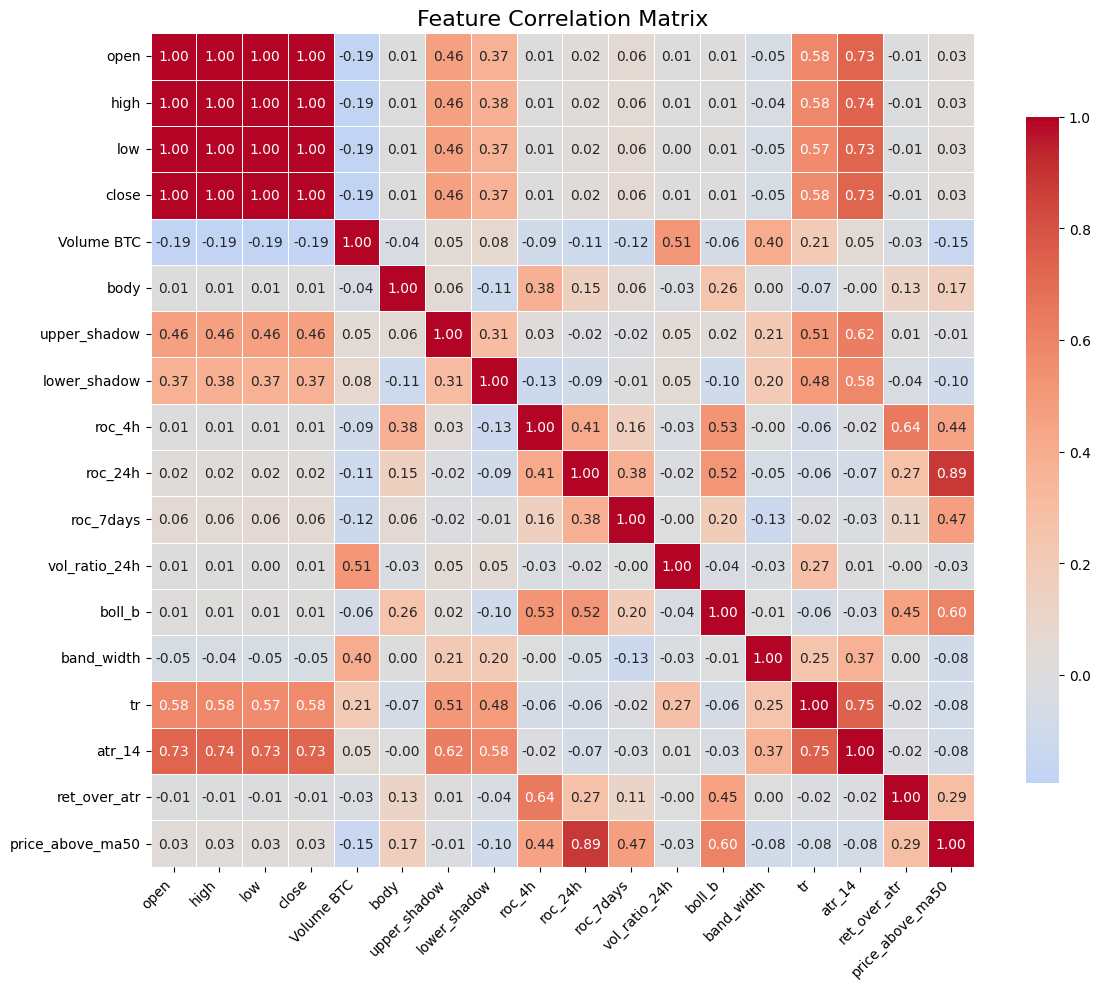

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ───────────── Load the file ─────────────
path = r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version_with_features_2018_final.csv"
df = pd.read_csv(path)

# ───────────── Optional: remove non-numeric columns ─────────────
df_numeric = df.select_dtypes(include=['number'])

# ───────────── Compute correlation matrix ─────────────
corr_matrix = df_numeric.corr()

# ───────────── Plot heatmap ─────────────
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Feature Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd

# Set file path
file_path = r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version_with_features_2018_final.csv"

# Load the dataset
df = pd.read_csv(file_path)

# Select only numeric columns
numeric_df = df.select_dtypes(include='number')

# Compute the correlation matrix
corr_matrix = numeric_df.corr().round(2)

# Print the correlation matrix in a readable format
print("🔍 Correlation Matrix (Pearson):")
print(corr_matrix.to_string())


🔍 Correlation Matrix (Pearson):
                  open  high   low  close  Volume BTC  body  upper_shadow  lower_shadow  roc_4h  roc_24h  roc_7days  vol_ratio_24h  boll_b  band_width    tr  atr_14  ret_over_atr  price_above_ma50
open              1.00  1.00  1.00   1.00       -0.19  0.01          0.46          0.37    0.01     0.02       0.06           0.01    0.01       -0.05  0.58    0.73         -0.01              0.03
high              1.00  1.00  1.00   1.00       -0.19  0.01          0.46          0.38    0.01     0.02       0.06           0.01    0.01       -0.04  0.58    0.74         -0.01              0.03
low               1.00  1.00  1.00   1.00       -0.19  0.01          0.46          0.37    0.01     0.02       0.06           0.00    0.01       -0.05  0.57    0.73         -0.01              0.03
close             1.00  1.00  1.00   1.00       -0.19  0.01          0.46          0.37    0.01     0.02       0.06           0.01    0.01       -0.05  0.58    0.73         -0.01  

Below is a concise review of the four pairs you listed **plus three high-leverage pairs that were missed**. I’ve kept the same layout and added an “✅ / ⚠️ / ❌” verdict for clarity.

| Feature A    | Feature B              | ρ (Pearson) | Why it’s high                                                                             | Verdict & Action                                                                                                                                                          |
| ------------ | ---------------------- | ----------- | ----------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **open**     | **high / low / close** | ≈ 1.00      | Derived from the same candlestick; no incremental signal once you retain one price level. | **✅ Drop** `open`, `high`, `low`; **keep** `close` (or compute a single “mid” price).                                                                                     |
| **roc\_24h** | **price\_above\_ma50** | 0.89        | Both encode medium-term trend direction.                                                  | **✅ Keep only one** – favour `price_above_ma50` (already smoothed & interpretable).                                                                                       |
| **roc\_4h**  | **ret\_over\_atr**     | 0.64        | `ret_over_atr` == `roc_4h / ATR`; adds a volatility-adjusted flavour.                     | **⚠️ Keep both for tree/NN models** (they exploit non-linear combos). **❌ Drop one in linear/logistic models** to control multicollinearity; usually keep `ret_over_atr`. |
| **close**    | **atr\_14**            | 0.73        | Sustained up-moves widen ATR. Correlation stems from trend, not construction.             | **⚠️ Accept** – they measure different concepts (level vs. volatility). No action.                                                                                        |

### Pairs that were overlooked

| Feature A      | Feature B              | ρ               | Why it matters                                                        | Suggested Solution                                                                                                 |
| -------------- | ---------------------- | --------------- | --------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------ |
| **tr**         | **atr\_14**            | 0.75            | ATR is a 14-period mean of TR, so information is duplicated.          | **✅ Keep only `atr_14`** (smoother) **OR** keep `tr` if you want raw, fast-moving range; not both.                 |
| **Volume BTC** | **vol\_ratio\_24h**    | 0.51 (moderate) | Ratio normalises volume; raw size rarely helps once ratio is present. | **✅ Drop** `Volume BTC`, **keep** `vol_ratio_24h`.                                                                 |
| **boll\_b**    | **roc\_4h / roc\_24h** | ≈ 0.53–0.55     | Bollinger %b rises with positive returns; partial redundancy.         | If you keep `%b`, you can **❌ drop one return feature** (usually `roc_24h`). Otherwise keep returns and drop `%b`. |

### Updated quick-start feature set

```
close, body, upper_shadow, lower_shadow,
roc_4h, ret_over_atr, price_above_ma50,   # keep ONE of roc_4h vs ret_over_atr vs price_above_ma50
vol_ratio_24h,
atr_14,                                   # or tr (pick one)
boll_b                                    # optional: drop if using both roc_4h & roc_24h
```

That leaves **8–10 low-redundancy features**—a solid base for Random Forest/XGBoost and easy to expand with lags or interactions later.
